### Demonstration of maximum entropy optimization under moment constraints

Maximize entropy $-\sum_i p_i \log p_i$ s.t. normalization $\sum_i p_i = 1$ (zeroth-order moment) and similarly 1st and 2nd moments; $\sum_i q_i p_i = m_1$, $\sum_i q^2_i p_i = m_2$ (e.g. "non-central" moments). The solution vector $p_i$ to this convex optimization problem is the normal distribution (technically, the domain should be infinite and two-sided for this to hold).  

In [1]:
import numpy as np
import ipmlineq
import scipy.sparse as scis
import matplotlib.pyplot as plt

In [2]:
def obj(x):
    val = np.sum(x * np.log(x))
    g = 1 + np.log(x)
    H = scis.diags(1.0 / x)
    return val, g, H

nx = 2000

C0 = np.ones((1, nx))
d0 = np.ones((1, ))

qa = -6
qb = +4

q = np.linspace(qa, qb, nx)

mu = -1.0
sgma = 1.25

C1 = q.reshape((1, nx))
d1 = np.array([mu])  # this is m1 = mu

C2 = (q ** 2).reshape((1, nx))
d2 = np.array([d1[0] ** 2 + sgma ** 2])  # value here is mu^2 + sigma^2

ptrue = (1.0 / (sgma * np.sqrt(2.0 * np.pi))) * np.exp(-0.5 * ((q - mu) / sgma) ** 2)
print(np.sum(ptrue) * (qb - qa) / (nx - 1))


0.9999371916760852


The second moment is related to the standard deviation by $m_2 = m_1^2 + \sigma^2$. If the interval of values $q_i$ is non-symmetric the solutions are more interesting. If it is symmetric, the odd moments vanish if the 1st and 2nd moments are constrained under maximum entropy (normal distribution is the continuous true solution). If only the zeroth moment is constrained, the maximum entropy solution is a uniform vector. The same is true if the first moment is also constrained (but only if the finite interval is centered around the mean, as it is in this demo). Then the Gaussian shape appears when moments $0$, $1$, and $2$ are all specified.

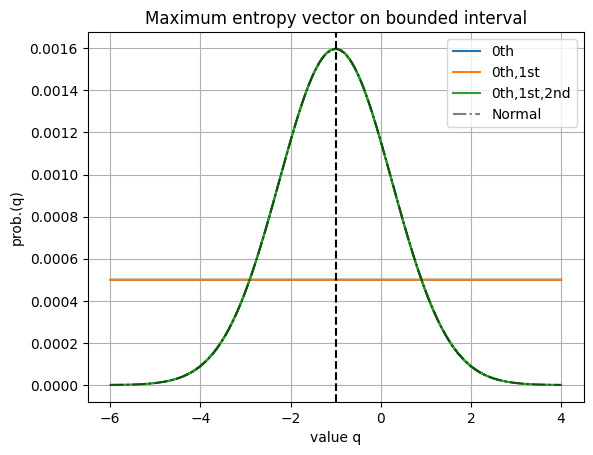

* non-central moments
l=0 non-central moment = 1.0000000000429203
l=1 non-central moment = -1.0000000000429206
l=2 non-central moment = 2.562500000401088
l=3 non-central moment = -5.6875000011174235
* central moments
l=1 central moment = -4.440892098500626e-16
l=2 central moment = 1.5625000003581668
l=3 central moment = -1.5543122344752192e-15
l=4 central moment = 7.290139819539725
l=5 central moment = -1.5987211554602254e-14
l=6 central moment = 55.96590506042149
l=7 central moment = -1.5631940186722204e-13
l=8 central moment = 586.5224623552906
l=9 central moment = -2.0463630789890885e-12
sigma^2 = 1.5625


In [3]:
res0 = ipmlineq.solveDenseOrSparseOnlyEq(obj, 
                                         C0, 
                                         d0, 
                                         x0 = np.ones((nx, )), 
                                         epstop = 1.0e-8, 
                                         verbose = False, 
                                         forcePos = True)
assert res0['converged']

res1 = ipmlineq.solveDenseOrSparseOnlyEq(obj, 
                                         np.vstack([C0, C1]), 
                                         np.hstack([d0, d1]), 
                                         x0 = np.ones((nx, )), 
                                         epstop = 1.0e-8, 
                                         verbose = False, 
                                         forcePos = True)
assert res1['converged']

res2 = ipmlineq.solveDenseOrSparseOnlyEq(obj, 
                                         np.vstack([C0, C1, C2]), 
                                         np.hstack([d0, d1, d2]), 
                                         x0 = np.ones((nx, )), 
                                         epstop = 1.0e-8, 
                                         verbose = False, 
                                         forcePos = True)
assert res2['converged']

plt.step(q, res0['x'], label = '0th')
plt.step(q, res1['x'], label = '0th,1st')
plt.step(q, res2['x'], label = '0th,1st,2nd')
plt.plot(q, ptrue * (qb - qa) / (nx - 1), label = 'Normal', alpha = 0.50, linestyle = '-.', color = 'k')
plt.xlabel('value q')
plt.ylabel('prob.(q)')
plt.title('Maximum entropy vector on bounded interval')
plt.axvline(x = d1[0], linestyle = '--', color = 'k')
plt.grid(True)
plt.legend()
plt.show()

print('* non-central moments')
for l in range(4):
    print('l={} non-central moment = {}'.format(l, np.sum( (q ** l) * res2['x'])))

print('* central moments')
for l in range(1,10):
    print('l={} central moment = {}'.format(l, np.sum( ((q - d1[0]) ** l) * res2['x'])))

print('sigma^2 = {}'.format(sgma ** 2))

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -7.6009e+00  1e+00  1e+00  1e+00
 1: -1.7937e+00 -7.4185e+00  9e-01  7e-01  8e-01
 2: -4.5441e+00 -7.1730e+00  5e-01  4e-01  4e-01
 3: -5.8171e+00 -7.0373e+00  3e-01  2e-01  2e-01
 4: -6.4022e+00 -6.9747e+00  2e-01  9e-02  1e-01
 5: -6.6754e+00 -6.9508e+00  9e-02  4e-02  8e-02
 6: -6.9458e+00 -6.9398e+00  9e-04  7e-04  2e-02
 7: -6.9399e+00 -6.9398e+00  9e-06  1e-05  8e-04
 8: -6.9398e+00 -6.9398e+00  9e-08  1e-07  1e-05
 9: -6.9398e+00 -6.9398e+00  9e-10  1e-09  1e-07
10: -6.9398e+00 -6.9398e+00  9e-12  1e-11  1e-09
Optimal solution found.


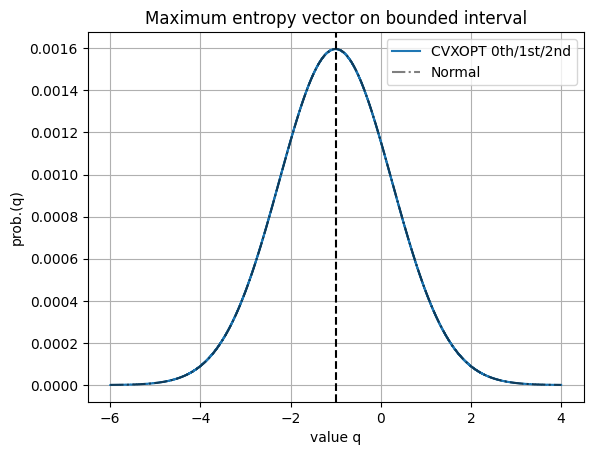

1.2716618123104206e-13


In [4]:
# Confirm the solution using CVXOPT
import cvxopt as cvx

def maxent(A, b):
    m, n = A.size
    def F(x=None, z=None):
        if x is None: return 0, cvx.matrix(1.0 / n, (n,1))
        if min(x) <= 0.0: return None
        f = sum(cvx.mul(x, cvx.log(x)))
        Df = (1 + cvx.log(x)).T
        if z is None: return f, Df
        H = cvx.spdiag(z[0] * x**-1)
        return f, Df, H
    return cvx.solvers.cp(F, A=A, b=b)['x']

Ccvx = cvx.matrix(np.vstack([C0, C1, C2]))
dcvx = cvx.matrix(np.vstack([d0, d1, d2]))

x2 = maxent(Ccvx, dcvx)
x2np = np.array(x2).flatten()

plt.step(q, x2, label = 'CVXOPT 0th/1st/2nd')
plt.plot(q, ptrue * (qb - qa) / (nx - 1), label = 'Normal', alpha = 0.50, linestyle = '-.', color = 'k')
plt.xlabel('value q')
plt.ylabel('prob.(q)')
plt.title('Maximum entropy vector on bounded interval')
plt.axvline(x = d1[0], linestyle = '--', color = 'k')
plt.grid(True)
plt.legend()
plt.show()

print(np.max(np.abs(res2['x'] - x2np)))